# Simulation of BBOB F01

Approach:
- SVM with RBF-Kernel
- 1000 random samples

In [16]:
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from utils.utils import create_problem, plot_collage
from utils.optimizer import perform_optimization
from gt_sampling import get_sample

## Create Groundtruth

In [4]:
n_dim = 2
samples = 1000
seed = 42

problem_f01 = create_problem(1, n_dim, seed)

## Sample from Groundtruth

In [5]:
sample_f01 = get_sample(problem_f01, n_samples=samples, n_dim=2, seed=42, method='random')

In [6]:
X_input = torch.tensor(sample_f01[0], dtype=torch.float32).clone().detach()
y_input = sample_f01[1].float()     

## Train SVM for Simulation

In [7]:
svm_p1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=10, gamma=0.6)),
])

In [8]:
svm_p1.fit(X_input, y_input)

Pipeline(steps=[('scaler', StandardScaler()), ('model', SVR(C=10, gamma=0.6))])

Export model:

In [ ]:
FOLDER = '../models'
svm1 = pickle.loads(open(f'{FOLDER}/SVM_grad.pkl', 'rb').read())

## Evaluation

### Graphical Evaluation

In [9]:
x1 = x2 = np.linspace(-5.0, 5.0, 100)
X1, X2 = np.meshgrid(x1, x2)
    
mesh_samples = np.c_[X1.ravel(), X2.ravel()]
mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
mesh_results = svm_p1.predict(mesh_samples_tensor).reshape(X1.shape)

c:\Users\User\.conda\envs\MachineLearningProject\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

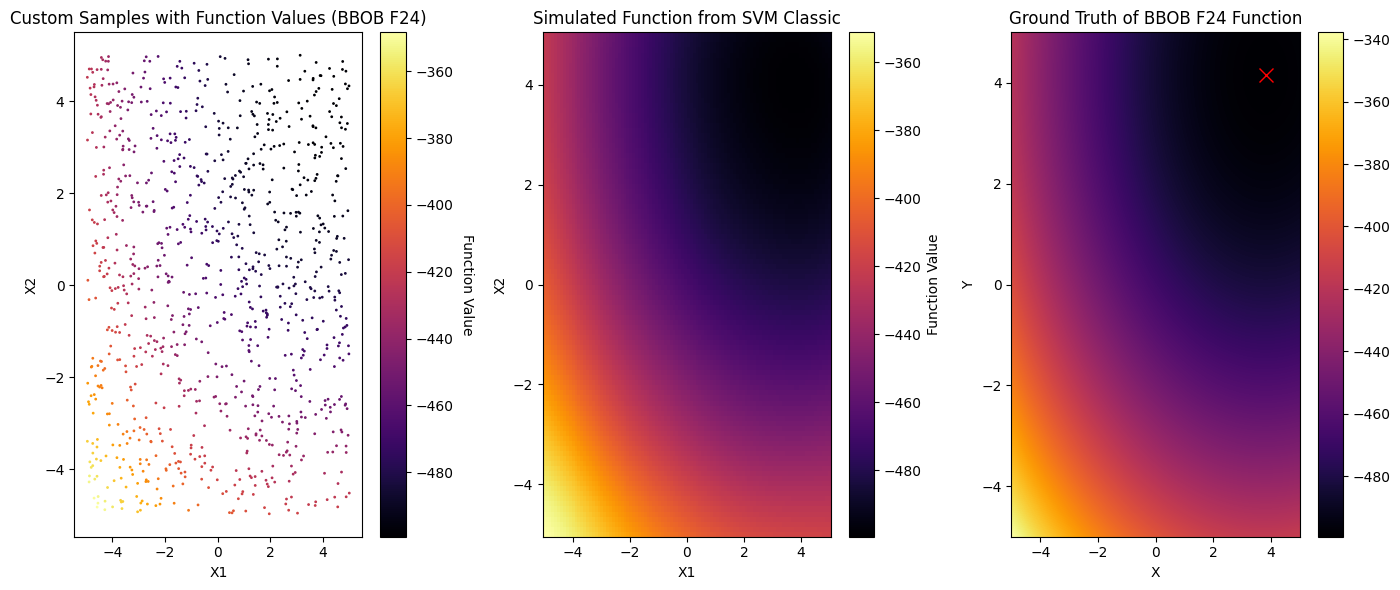

In [10]:
plot_collage(sample_f01[0], sample_f01[1], problem_f01, "BBOB F24", "SVM Classic", X1, X2, mesh_results)

In [13]:
FOLDER = '../models'
pickle.dump(svm_p1, open(f'{FOLDER}/SVM-P01-Classic.pkl', 'wb'))

on first glance: Classic SVM with RBF-Kernel can simulate the first BBOB function quite well

### Evaluation with metrics

tbd

### Evaluation with optimizer

In [27]:
svm_classic_f = lambda x: svm_p1.predict(x.reshape(1, -1))

functions = [[problem_f01, 'Groundtruth']
             , [svm_classic_f, 'SVM-Classic']
]

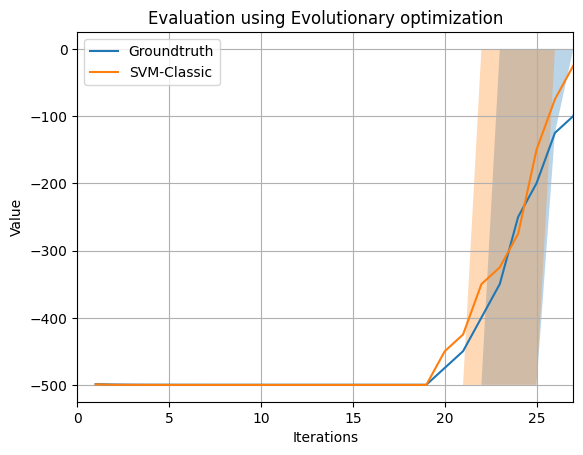

In [31]:
n_times = 20  # Number of times to repeat
i_evaluations = 100  # Number of evaluations
optimization_type = "Evolutionary"

for elem in functions:

    results = []
    # optimum = get_optimum(elem[0])

    # Perform random search 'n_times' times and store the results
    for _ in range(n_times):
        best_inputs, best_outputs = perform_optimization(optimization_type, elem[0], n_dim, num_iterations=i_evaluations)
        results.append(np.array(best_outputs))

    # append the elements of results to the same length as the longest
    # Find the maximum length
    max_length = max(len(arr) for arr in results)

    # Initialize a list to store the padded arrays
    padded_array_list = []

    # Loop through the original list and pad arrays
    for arr in results:
        padding_length = max_length - len(arr)
        padded_arr = np.pad(arr, (0, padding_length), mode='constant', constant_values=0)
        padded_array_list.append(padded_arr)

    results = padded_array_list

    # Calculate the mean and interquartile range (IQR) for each evaluation
    mean_values = np.mean(results, axis=0)
    q1 = np.percentile(results, 75, axis=0) 
    q3 = np.percentile(results, 25, axis=0)

    x = [i for i in range(1, len(mean_values)+1)]

    plt.plot(x, mean_values, label=f'{elem[1]}')
    plt.fill_between(x, q1, q3,  alpha=0.3)


plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.xlim(0, len(mean_values))
plt.title(f'Evaluation using {optimization_type} optimization')
plt.grid(True)
plt.show()